# Idle States Residency Analysis

This notebook shows the features provided by the idle state analysis module. It will be necessary to collect the following events:

 - `cpu_idle`, to filter out intervals of time in which the CPU is idle
 - `sched_switch`, to recognise tasks on kernelshark

In [1]:
import logging
reload(logging)
log_fmt = '%(asctime)-9s %(levelname)-8s: %(message)s'
logging.basicConfig(format=log_fmt)

# Change to info once the notebook runs ok
logging.getLogger().setLevel(logging.INFO)

In [2]:
%matplotlib inline

import os

# Support to access the remote target
from env import TestEnv

# Support to configure and run RTApp based workloads
from wlgen import RTA, Ramp

# Support for trace events analysis
from trace import Trace

# Target Configuration

Our target is a Juno R2 development board running Linux.

In [3]:
# Setup a target configuration
my_conf = {
    
    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : "/home/lisa/android-sdk",
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
            'ip_address'     : '10.169.36.36',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },  

    
    "results_dir" : "CPUIdleAnalysis",
    
    # RTApp calibration values (comment to let LISA do a calibration run)

    # Tools required by the experiments
    "tools"   : ['rt-app', 'trace-cmd'],
    "modules" : ['bl', 'cpufreq'],
    "exclude_modules" : ['hwmon'],
    
    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "cpu_idle",
            "sched_switch"
         ],
         "buffsize" : 10 * 1024,
    },
}

# Tests execution

In [4]:
# Initialize a test environment
te = TestEnv(my_conf)
target = te.target

2017-09-08 02:51:29,534 INFO    : Using base path: /home/lisa/lisa-github
2017-09-08 02:51:29,536 INFO    : Loading custom (inline) target configuration
2017-09-08 02:51:29,537 WARNING : Wipe previous contents of the results folder:
2017-09-08 02:51:29,538 WARNING :    /home/lisa/lisa-github/results/CPUIdleAnalysis
2017-09-08 02:51:29,543 INFO    : External tools using:
2017-09-08 02:51:29,544 INFO    :    ANDROID_HOME: /home/lisa/android-sdk
2017-09-08 02:51:29,545 INFO    :    CATAPULT_HOME: /home/lisa/lisa-github/tools/catapult
2017-09-08 02:51:29,546 INFO    : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq']
2017-09-08 02:51:29,548 INFO    : Connecting Android target [0123456789ABCDEF]
2017-09-08 02:51:29,549 INFO    : Connection settings:
2017-09-08 02:51:29,550 INFO    :    {'device': '0123456789ABCDEF'}
2017-09-08 02:51:30,138 INFO    : Initializing target workdir:
2017-09-08 02:51:30,140 INFO    :    /data/local/tmp/devlib-target
2017-09-08 02:51:32,557 INFO    : Attempting

# Workload configuration and execution

In [5]:
def experiment(te):

    # Create RTApp RAMP task
    rtapp = RTA(te.target, 'ramp', calibration=te.calibration())
    rtapp.conf(kind='profile',
               params={
                    'ramp' : Ramp(
                        start_pct =  60,
                        end_pct   =  20,
                        delta_pct =   5,
                        time_s    =   0.5).get()
              })

    # FTrace the execution of this workload
    te.ftrace.start()
    rtapp.run(out_dir=te.res_dir)
    te.ftrace.stop()

    # Collect and keep track of the trace
    trace_file = os.path.join(te.res_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)

    # Dump platform descriptor
    te.platform_dump(te.res_dir)

In [6]:
experiment(te)

2017-09-08 02:51:35,725 INFO    : Setup new workload ramp
2017-09-08 02:51:35,786 INFO    : Workload duration defined by longest task
2017-09-08 02:51:35,788 INFO    : Default policy: SCHED_OTHER
2017-09-08 02:51:35,789 INFO    : ------------------------
2017-09-08 02:51:35,790 INFO    : task [ramp], sched: using default policy
2017-09-08 02:51:35,791 INFO    :  | loops count: 1
2017-09-08 02:51:35,793 INFO    : + phase_000001: duration 0.500000 [s] (5 loops)
2017-09-08 02:51:35,794 INFO    : |  period   100000 [us], duty_cycle  60 %
2017-09-08 02:51:35,796 INFO    : |  run_time  60000 [us], sleep_time  40000 [us]
2017-09-08 02:51:35,797 INFO    : + phase_000002: duration 0.500000 [s] (5 loops)
2017-09-08 02:51:35,798 INFO    : |  period   100000 [us], duty_cycle  55 %
2017-09-08 02:51:35,799 INFO    : |  run_time  55000 [us], sleep_time  45000 [us]
2017-09-08 02:51:35,800 INFO    : + phase_000003: duration 0.500000 [s] (5 loops)
2017-09-08 02:51:35,801 INFO    : |  period   100000 [us

# Parse trace and analyse data

In [7]:
# Base folder where tests folder are located
res_dir = te.res_dir
logging.info('Content of the output folder %s', res_dir)
!tree {res_dir}

2017-09-08 02:51:45,189 INFO    : Content of the output folder /home/lisa/lisa-github/results/CPUIdleAnalysis


/home/lisa/lisa-github/results/CPUIdleAnalysis
|-- output.log
|-- platform.json
|-- ramp_00.json
|-- rt-app-ramp-0.log
|-- rt-app-ramp_1-0.log
|-- rt-app-ramp_1-2.log
|-- rt-app-ramp_1-4.log
|-- rt-app-ramp_2-3.log
|-- rt-app-ramp_2-5.log
`-- trace.dat

0 directories, 10 files


In [8]:
my_conf['ftrace']['events']

['cpu_idle', 'sched_switch']

In [9]:
my_conf['ftrace']['events']
import json
with open(os.path.join(res_dir, 'platform.json'), 'r') as fh:
    platform = json.load(fh)
trace = Trace(platform, te.res_dir, events=my_conf['ftrace']['events'])

In [10]:
import trappy

# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.sched.SchedLoadAvgTask object at 0x7f00d1142910> from cache, reading it from trace
  warnings.warn(warnstr)
/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.SchedContribScaleFactor object at 0x7f00d1142dd0> from cache, reading it from trace
  warnings.warn(warnstr)
/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.cpu_power.CpuOutPower object at 0x7f00d1142f90> from cache, reading it from trace
  warnings.warn(warnstr)
/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.sched.SchedCpuCapacity object at 0x7f00d1142f10> from cache, reading it from trace
  warnings.warn(warnstr)
/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.sched.SchedLoadAvgSchedGroup object at 0x7f00d0798a10> from 

## Per-CPU Idle State Residency

It is possible to get the residency in each idle state of a CPU or a cluster with the following commands:

In [11]:
# Idle state residency for CPU 3
trace.data_frame.cpu_idle_state_residency(4)

,time
idle_state,
0,0.000000
1,0.066057
2,0.413471
3,2.854543


The `IdleAnalysis` module provide methods for plotting residency data.

In [12]:
ia = trace.analysis.idle

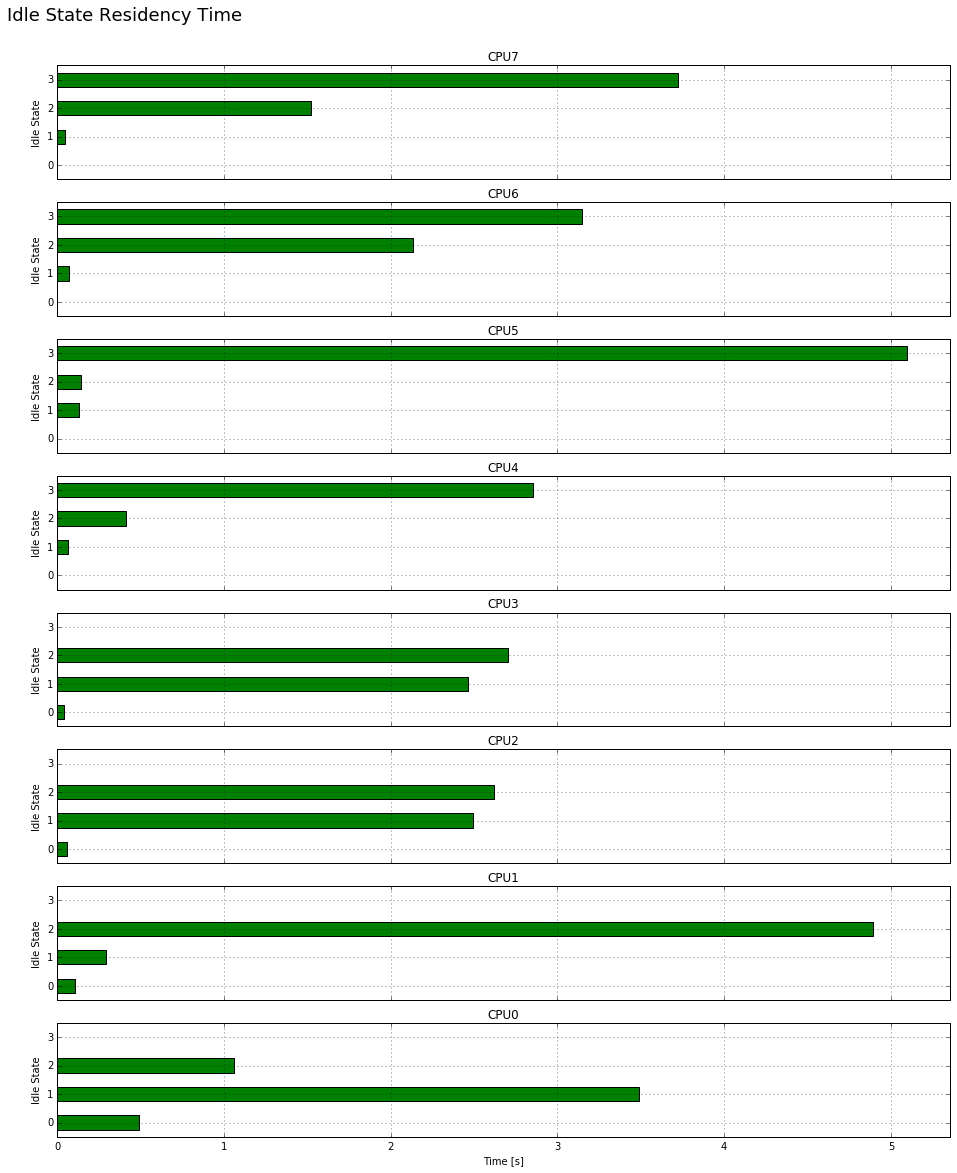

In [13]:
# Actual time spent in each idle state
ia.plotCPUIdleStateResidency([0, 1,2, 3, 4, 5,6,7])

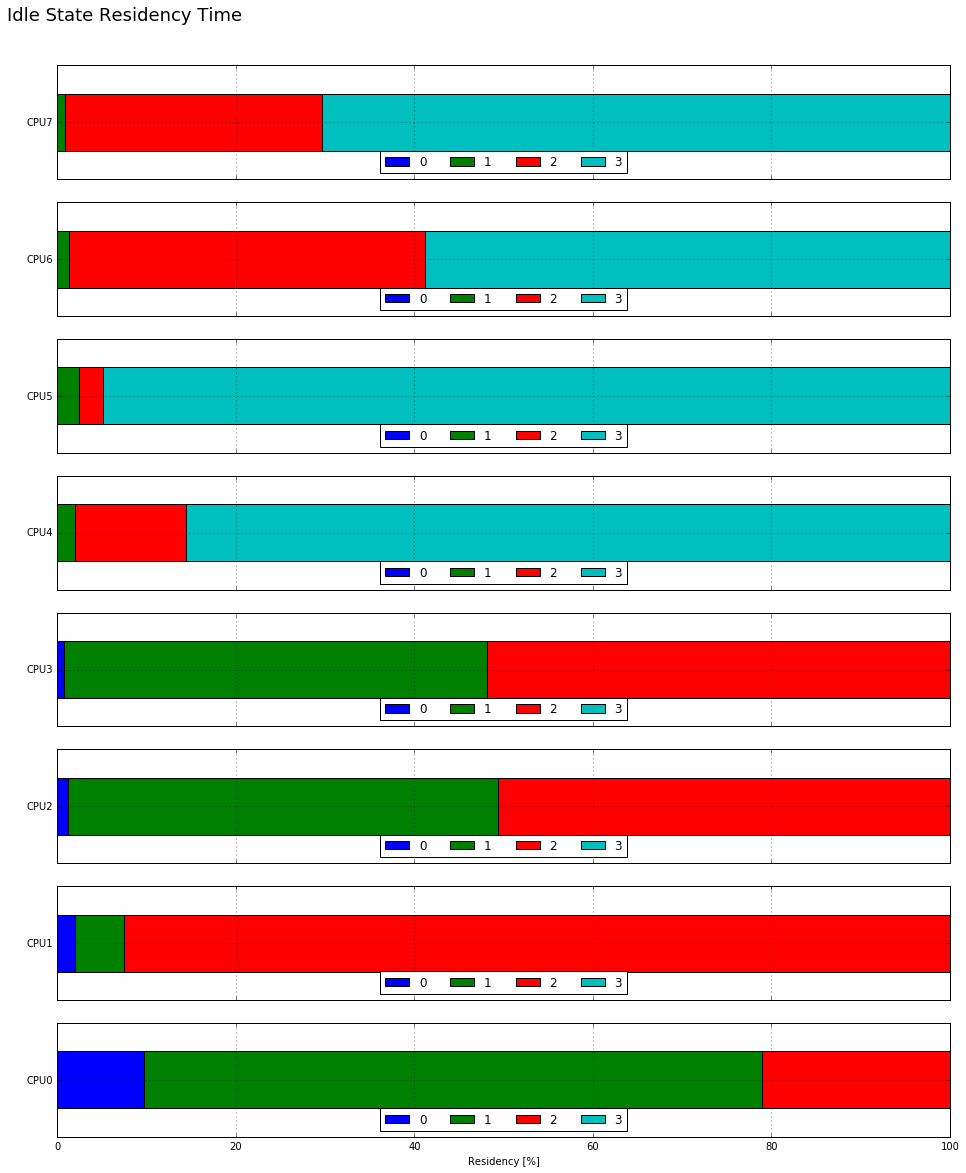

In [14]:
# Percentage of time spent in each idle state
ia.plotCPUIdleStateResidency([0,1,2,3,4,5,6,7], pct=True)

## Per-cluster Idle State Residency

In [15]:
# Idle state residency for the big cluster
trace.data_frame.cluster_idle_state_residency('big')

,time
idle_state,
0,0.000000
1,0.130935
2,1.169711
3,1.928194


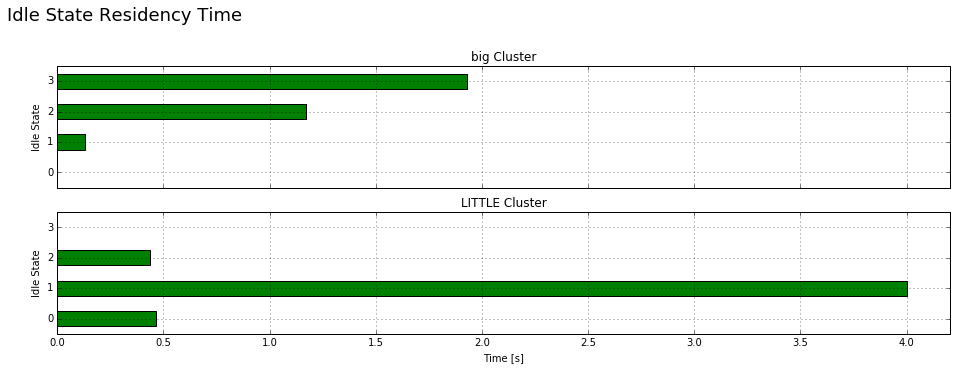

In [16]:
ia.plotClusterIdleStateResidency(['big', 'LITTLE'])

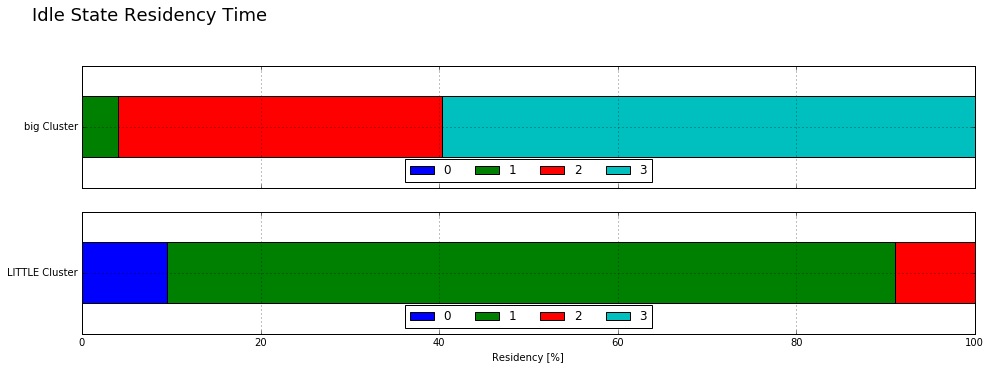

In [17]:
ia.plotClusterIdleStateResidency(['big', 'LITTLE'], pct=True)